In [ ]:
!pip install torch torchvision matplotlib
!pip install --upgrade torch torchvision torchaudio
!pip install pytorch-fid scikit-learn seaborn
!pip install pytorch-fid torch-fidelity

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 93.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 41.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 97.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import os, torch, copy
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils
from torch.nn.utils import spectral_norm
from torch.amp import autocast
from torch.cuda.amp import GradScaler
from torch.cuda.amp import GradScaler, autocast
import os
from torchvision.utils import save_image
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd
from collections import defaultdict
import os, torch
import seaborn as sns
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
from sklearn.manifold import TSNE

Configuration and Dataset Loading

In [ ]:
image_size = 128
batch_size = 128
nz = 256
embedding_dim = 256
num_classes = 21
num_epochs = 200
lr_g, lr_d = 0.0001, 0.0004
betas = (0.0, 0.99)
ema_decay = 0.999
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True


In [ ]:
dataset_path = '/content/drive/MyDrive/GRAVITY SPY DATASET'
print(os.listdir(dataset_path))

['trainingset_v1d1_metadata.csv', 'train', 'test', 'validation']


In [ ]:
metadata_df = pd.read_csv('/content/drive/MyDrive/GRAVITY SPY DATASET/trainingset_v1d1_metadata.csv')
metadata_df.label.value_counts()

label
Blip                   1821
Koi_Fish                706
Low_Frequency_Burst     621
Light_Modulation        512
Power_Line              449
Extremely_Loud          447
Low_Frequency_Lines     447
Scattered_Light         443
Violin_Mode             412
Scratchy                337
1080Lines               328
Whistle                 299
Helix                   279
Repeating_Blips         263
No_Glitch               150
Tomte                   103
None_of_the_Above        81
1400Ripples              81
Chirp                    60
Air_Compressor           58
Wandering_Line           42
Paired_Doves             27
Name: count, dtype: int64

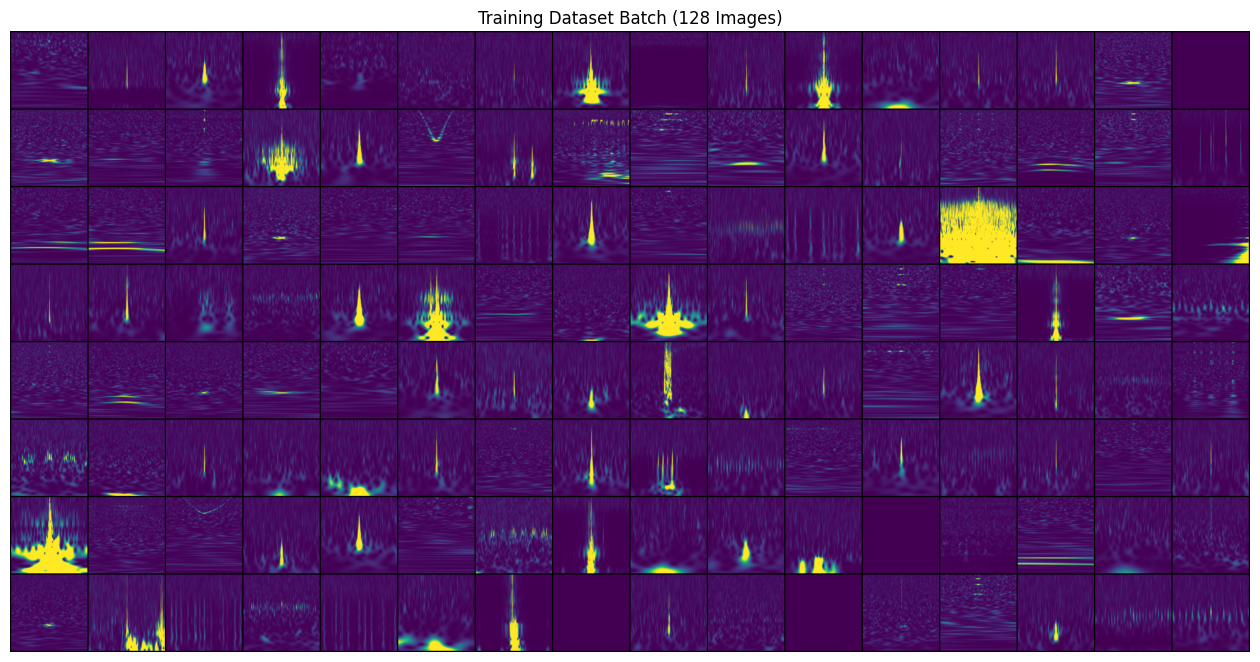

In [ ]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

batch_size = 128
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

dataset = datasets.ImageFolder(root=data_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)
real_batch = next(iter(dataloader))
images, labels = real_batch

plt.figure(figsize=(16, 16))
grid = vutils.make_grid(images[:128], nrow=16, padding=2, normalize=True)
plt.imshow(grid.permute(1, 2, 0).cpu())
plt.title("Training Dataset Batch (128 Images)")
plt.axis("off")
plt.show()


In [ ]:
train_classes = os.listdir('/content/drive/MyDrive/GRAVITY SPY DATASET' + "/train"+'/train')
print(train_classes)

['Wandering_Line', 'Scratchy', 'Power_Line', 'Repeating_Blips', 'Tomte', 'Scattered_Light', 'Whistle', 'Violin_Mode', 'Chirp', 'Koi_Fish', 'No_Glitch', 'None_of_the_Above', 'Extremely_Loud', 'Low_Frequency_Burst', 'Paired_Doves', 'Light_Modulation', 'Helix', 'Low_Frequency_Lines', '1400Ripples', 'Air_Compressor', 'Blip', '1080Lines']


In [ ]:
test_classes = os.listdir('/content/drive/MyDrive/GRAVITY SPY DATASET' + "/test"+'/test')
print(test_classes)

['Violin_Mode', 'Wandering_Line', 'Scattered_Light', 'Tomte', 'Whistle', 'Scratchy', 'Low_Frequency_Lines', 'Power_Line', 'Repeating_Blips', 'None_of_the_Above', 'Paired_Doves', 'Low_Frequency_Burst', 'Light_Modulation', 'No_Glitch', 'Koi_Fish', 'Helix', '1400Ripples', 'Extremely_Loud', 'Air_Compressor', 'Chirp', '1080Lines', 'Blip']


In [ ]:
validation_classes = os.listdir('/content/drive/MyDrive/GRAVITY SPY DATASET' + "/validation"+'/validation')
print(validation_classes)

['Paired_Doves', 'Whistle', 'Repeating_Blips', 'Scratchy', 'Power_Line', 'Tomte', 'No_Glitch', 'Wandering_Line', 'Scattered_Light', 'Violin_Mode', 'Chirp', 'Koi_Fish', 'Extremely_Loud', 'Helix', 'Low_Frequency_Burst', 'None_of_the_Above', 'Low_Frequency_Lines', 'Blip', 'Air_Compressor', 'Light_Modulation', '1400Ripples', '1080Lines']


In [ ]:
data_path = '/content/drive/MyDrive/GRAVITY SPY DATASET/train/train'
checkpoint_dir = '/content/drive/MyDrive/GAN128_RGB_Tuned/Checkpoints'
sample_dir = '/content/drive/MyDrive/GAN128_RGB_Tuned/Samples'
gen_save_dir = '/content/drive/MyDrive/GAN_Generated_Images'
os.makedirs(checkpoint_dir, exist_ok=True)
os.makedirs(sample_dir, exist_ok=True)
os.makedirs(gen_save_dir, exist_ok=True)

Filtered Dataset Loader

In [ ]:
# Data transformation pipeline and Custom dataset class that excludes 'None_of_the_Above'
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])
class FilteredImageFolder(datasets.ImageFolder):
    def find_classes(self, directory):
        classes = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
        classes.sort()
        if 'None_of_the_Above' in classes:
            classes.remove('None_of_the_Above')
        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        return classes, class_to_idx
dataset = FilteredImageFolder(root=data_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
print(f"Filtered Dataset: {len(dataset)} images across {len(dataset.classes)} classes.")

Filtered Dataset: 22141 images across 21 classes.


Generator & Discriminator (Conditional DCGAN)

In [ ]:
# Generator with class conditioning and transposed convolutions
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.label_emb = nn.Embedding(num_classes, embedding_dim)
        self.init_proj = nn.Linear(nz + embedding_dim, 2048 * 4 * 4)

        self.model = nn.Sequential(
            nn.ConvTranspose2d(2048, 1024, 4, 2, 1), nn.BatchNorm2d(1024), nn.ReLU(True), nn.Dropout(0.3),
            nn.ConvTranspose2d(1024, 512, 4, 2, 1),  nn.BatchNorm2d(512),  nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1),   nn.BatchNorm2d(256),  nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1),   nn.BatchNorm2d(128),  nn.ReLU(True),
            nn.ConvTranspose2d(128, 3, 4, 2, 1),     nn.Tanh()
        )

    def forward(self, z, labels):
        label_embedding = self.label_emb(labels)
        x = torch.cat([z, label_embedding], dim=1)
        x = self.init_proj(x).view(-1, 2048, 4, 4)
        return self.model(x)

In [ ]:
# Discriminator with projection and spectral normalization
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.label_emb = nn.Embedding(num_classes, 8192)

        self.conv = nn.Sequential(
            spectral_norm(nn.Conv2d(3, 64, 4, 2, 1)),   nn.LeakyReLU(0.2, inplace=True), nn.Dropout(0.3),
            spectral_norm(nn.Conv2d(64, 128, 4, 2, 1)), nn.LeakyReLU(0.2, inplace=True), nn.Dropout(0.3),
            spectral_norm(nn.Conv2d(128, 256, 4, 2, 1)),nn.LeakyReLU(0.2, inplace=True), nn.Dropout(0.3),
            spectral_norm(nn.Conv2d(256, 512, 4, 2, 1)),nn.LeakyReLU(0.2, inplace=True), nn.Dropout(0.3),
            spectral_norm(nn.Conv2d(512, 512, 4, 2, 1)),nn.LeakyReLU(0.2, inplace=True), nn.Dropout(0.3),
        )
        self.fc = spectral_norm(nn.Linear(512 * 4 * 4, 1))

    def forward(self, x, labels):
        out = self.conv(x).view(x.size(0), -1)
        logits = self.fc(out)
        proj = torch.sum(out * self.label_emb(labels), dim=1, keepdim=True)
        return logits + proj


Initialization, Training & EMA Updates

In [ ]:
G = Generator().to(device)
D = Discriminator().to(device)
G_ema = copy.deepcopy(G).eval().to(device)

opt_G = optim.Adam(G.parameters(), lr=lr_g, betas=betas)
opt_D = optim.Adam(D.parameters(), lr=0.0002, betas=betas)
criterion = nn.BCEWithLogitsLoss()
scaler = GradScaler()
loss_history = {'G': [], 'D': []}

<ipython-input-107-eff4eb00e8ba>:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [ ]:
def update_ema(model, ema_model, decay=0.999):
    with torch.no_grad():
        for k, ema_v in ema_model.state_dict().items():
            ema_v.copy_(decay * ema_v + (1. - decay) * model.state_dict()[k])

Save Samples and Visualize Epoch Progress

In [ ]:
def save_samples(epoch, model=None, save_dir=None):
    if model is None:
        model = G_ema

    if save_dir is None:
        save_dir = sample_dir

    os.makedirs(save_dir, exist_ok=True)

    model.eval()
    with torch.no_grad():
        z = torch.randn(num_classes, nz, device=device)
        labels = torch.arange(num_classes, device=device)
        samples = model(z, labels)
        grid = utils.make_grid(samples, nrow=7, normalize=True, padding=2)
        out_path = os.path.join(save_dir, f"epoch_{epoch:03}.png")
        utils.save_image(grid, out_path)
        print(f" Saved image grid for epoch {epoch:03}: {out_path}")


In [ ]:
def plot_sample_comparison(epoch_list=[0, 50, 100, 150, 175, 200, 250], samples_dir=sample_dir):
    images = []
    for epoch in epoch_list:
        path = os.path.join(samples_dir, f"epoch_{epoch:03}.png")
        if os.path.exists(path):
            images.append(Image.open(path))
        else:
            print(f" Missing {path}")
    if images:
        plt.figure(figsize=(16, 4 * len(images)))
        for i, img in enumerate(images):
            plt.subplot(len(images), 1, i+1)
            plt.imshow(img)
            plt.title(f"Epoch {epoch_list[i]}")
            plt.axis('off')
        plt.tight_layout()
        plt.show()


Training Loop

In [ ]:
save_samples(epoch=0, model=G)

 Saved image grid for epoch 000: /content/drive/MyDrive/GAN128_RGB_Tuned/Samples_Epoch_050/epoch_000.png


In [ ]:
def train_gan_stage(start_epoch, end_epoch, G, D, G_ema, opt_G, opt_D, scaler, dataloader, loss_history):
    print(f" Starting training from epoch {start_epoch} to {end_epoch}...")

    for epoch in range(start_epoch, end_epoch):
        g_losses, d_losses = [], []

        for real_imgs, labels in dataloader:
            real_imgs, labels = real_imgs.to(device), labels.to(device)
            b = real_imgs.size(0)
            valid = torch.empty(b, 1, device=device).uniform_(0.8, 1.0)
            fake = torch.zeros(b, 1, device=device)

            real_imgs_noisy = real_imgs + 0.05 * torch.randn_like(real_imgs)

            # Generator
            z = torch.randn(b, nz, device=device)
            fake_labels = torch.randint(0, num_classes, (b,), device=device)
            opt_G.zero_grad()

            with autocast():
                gen_imgs = G(z, fake_labels)
                gen_imgs_noisy = gen_imgs + 0.05 * torch.randn_like(gen_imgs)
                g_loss = criterion(D(gen_imgs_noisy, fake_labels), valid)

            scaler.scale(g_loss).backward()
            scaler.step(opt_G)
            scaler.update()
            g_losses.append(g_loss.item())
            update_ema(G, G_ema, ema_decay)

            # Discriminator
            opt_D.zero_grad()
            with autocast():
                real_loss = criterion(D(real_imgs_noisy, labels), valid)
                fake_loss = criterion(D(gen_imgs_noisy.detach(), fake_labels), fake)
                d_loss = (real_loss + fake_loss) / 2

            scaler.scale(d_loss).backward()
            scaler.step(opt_D)
            scaler.update()
            d_losses.append(d_loss.item())

        loss_history['G'].append(torch.tensor(g_losses).mean().item())
        loss_history['D'].append(torch.tensor(d_losses).mean().item())
        print(f"[Epoch {epoch+1}] G: {loss_history['G'][-1]:.4f} | D: {loss_history['D'][-1]:.4f}")

        # Save checkpoints
        if (epoch + 1) in [50, 100, 150, 175, 200, 250]:
            save_samples(epoch + 1)
            torch.save({
                'G': G.state_dict(),
                'G_ema': G_ema.state_dict(),
                'D': D.state_dict(),
                'opt_G': opt_G.state_dict(),
                'opt_D': opt_D.state_dict(),
                'loss': loss_history,
                'epoch': epoch
            }, f"{checkpoint_dir}/ckpt_epoch_{epoch+1}.pth")

    print(f" Finished training stage: {start_epoch}–{end_epoch}")


In [ ]:
start_epoch = 0
end_epoch = 50
loss_history = {'G': [], 'D': []}

train_gan_stage(start_epoch, end_epoch, G, D, G_ema, opt_G, opt_D, scaler, dataloader, loss_history)


 Starting training from epoch 0 to 50...


<ipython-input-42-0dc6c445edd4>:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-42-0dc6c445edd4>:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[Epoch 1] G: 1.8499 | D: 0.4103
[Epoch 2] G: 1.8882 | D: 0.4127
[Epoch 3] G: 1.8562 | D: 0.4155
[Epoch 4] G: 1.8084 | D: 0.4206
[Epoch 5] G: 1.8610 | D: 0.4124
[Epoch 6] G: 1.8316 | D: 0.4131
[Epoch 7] G: 1.8604 | D: 0.4127
[Epoch 8] G: 1.8979 | D: 0.4014
[Epoch 9] G: 1.9445 | D: 0.3938
[Epoch 10] G: 1.9459 | D: 0.3964
[Epoch 11] G: 1.9844 | D: 0.3845
[Epoch 12] G: 2.0634 | D: 0.3751
[Epoch 13] G: 2.0393 | D: 0.3749
[Epoch 14] G: 2.1171 | D: 0.3627
[Epoch 15] G: 2.1391 | D: 0.3653
[Epoch 16] G: 2.1744 | D: 0.3569
[Epoch 17] G: 2.1574 | D: 0.3572
[Epoch 18] G: 2.2524 | D: 0.3450
[Epoch 19] G: 2.2385 | D: 0.3511
[Epoch 20] G: 2.2194 | D: 0.3532
[Epoch 21] G: 2.3743 | D: 0.3291
[Epoch 22] G: 2.2075 | D: 0.3559
[Epoch 23] G: 2.3142 | D: 0.3391
[Epoch 24] G: 2.3438 | D: 0.3349
[Epoch 25] G: 2.3610 | D: 0.3329
[Epoch 26] G: 2.2648 | D: 0.3463
[Epoch 27] G: 2.3287 | D: 0.3402
[Epoch 28] G: 2.3667 | D: 0.3300
[Epoch 29] G: 2.3834 | D: 0.3348
[Epoch 30] G: 2.3808 | D: 0.3275
[Epoch 31] G: 2.430

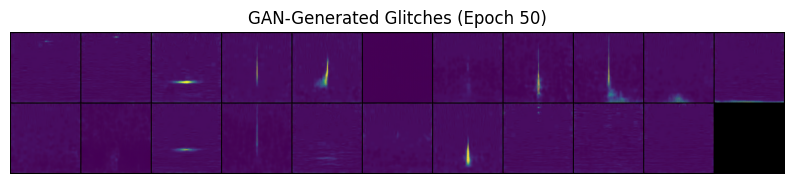

In [ ]:
grid_path = '/content/drive/MyDrive/GAN128_RGB_Tuned/Samples/epoch_050.png'
img = Image.open(grid_path)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.title("GAN-Generated Glitches (Epoch 50)")
plt.show()


In [ ]:
# Load checkpoint at epoch 50
ckpt_50 = torch.load("/content/drive/MyDrive/GAN128_RGB_Tuned/Checkpoints/ckpt_epoch_50.pth")
G_ema.load_state_dict(ckpt_50['G_ema'])

# Save with updated formatting to same folder
save_samples(epoch=50, model=G_ema, save_dir="/content/drive/MyDrive/GAN128_RGB_Tuned/Samples_Epoch_050")


 Saved image grid for epoch 050: /content/drive/MyDrive/GAN128_RGB_Tuned/Samples_Epoch_050/epoch_050.png


In [ ]:
ckpt = torch.load(f"{checkpoint_dir}/ckpt_epoch_50.pth")
G.load_state_dict(ckpt['G'])
G_ema.load_state_dict(ckpt['G_ema'])
D.load_state_dict(ckpt['D'])
opt_G.load_state_dict(ckpt['opt_G'])
opt_D.load_state_dict(ckpt['opt_D'])
loss_history = ckpt['loss']
start_epoch = ckpt['epoch'] + 1
end_epoch = 100

print(f" Resuming training from epoch {start_epoch} to {end_epoch}...")
# Fine-Tune: Lower Discriminator LR
for param_group in opt_D.param_groups:
    param_group['lr'] = 0.0001

train_gan_stage(start_epoch, end_epoch, G, D, G_ema, opt_G, opt_D, scaler, dataloader, loss_history)


 Resuming training from epoch 50 to 100...
 Starting training from epoch 50 to 100...


<ipython-input-42-0dc6c445edd4>:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-42-0dc6c445edd4>:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[Epoch 51] G: 2.2254 | D: 0.3293
[Epoch 52] G: 2.3088 | D: 0.3222
[Epoch 53] G: 2.3757 | D: 0.3179
[Epoch 54] G: 2.3805 | D: 0.3182
[Epoch 55] G: 2.2609 | D: 0.3361
[Epoch 56] G: 2.2369 | D: 0.3391
[Epoch 57] G: 2.2273 | D: 0.3359
[Epoch 58] G: 2.3417 | D: 0.3267
[Epoch 59] G: 2.3311 | D: 0.3302
[Epoch 60] G: 2.2238 | D: 0.3385
[Epoch 61] G: 2.1584 | D: 0.3543
[Epoch 62] G: 2.2179 | D: 0.3413
[Epoch 63] G: 2.3327 | D: 0.3235
[Epoch 64] G: 2.3188 | D: 0.3281
[Epoch 65] G: 2.3813 | D: 0.3187
[Epoch 66] G: 2.4799 | D: 0.3122
[Epoch 67] G: 2.4072 | D: 0.3172
[Epoch 68] G: 2.4496 | D: 0.3140
[Epoch 69] G: 2.4767 | D: 0.3095
[Epoch 70] G: 2.4309 | D: 0.3207
[Epoch 71] G: 2.3308 | D: 0.3217
[Epoch 72] G: 2.3705 | D: 0.3191
[Epoch 73] G: 2.3769 | D: 0.3188
[Epoch 74] G: 2.4132 | D: 0.3159
[Epoch 75] G: 2.3607 | D: 0.3242
[Epoch 76] G: 2.4858 | D: 0.3110
[Epoch 77] G: 2.4465 | D: 0.3125
[Epoch 78] G: 2.5082 | D: 0.3097
[Epoch 79] G: 2.5200 | D: 0.2988
[Epoch 80] G: 2.4923 | D: 0.3085
[Epoch 81]

Generate Balanced Dataset of 2000 Samples for each Class

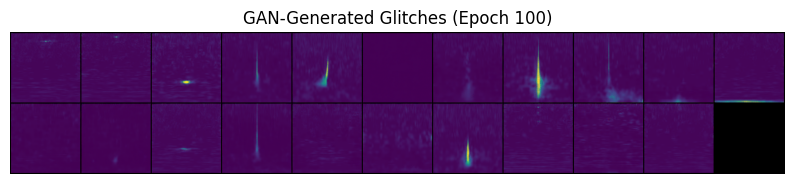

In [ ]:
grid_path = '/content/drive/MyDrive/GAN128_RGB_Tuned/Samples/epoch_100.png'
img = Image.open(grid_path)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.title("GAN-Generated Glitches (Epoch 100)")
plt.show()


In [ ]:
ckpt_100 = torch.load("/content/drive/MyDrive/GAN128_RGB_Tuned/Checkpoints/ckpt_epoch_100.pth")
G_ema.load_state_dict(ckpt_100['G_ema'])

save_samples(epoch=100, model=G_ema, save_dir="/content/drive/MyDrive/GAN128_RGB_Tuned/Samples_Epoch_050")


 Saved image grid for epoch 100: /content/drive/MyDrive/GAN128_RGB_Tuned/Samples_Epoch_050/epoch_100.png


In [ ]:
ckpt = torch.load(f"{checkpoint_dir}/ckpt_epoch_100.pth")
G.load_state_dict(ckpt['G'])
G_ema.load_state_dict(ckpt['G_ema'])
D.load_state_dict(ckpt['D'])
opt_G.load_state_dict(ckpt['opt_G'])
opt_D.load_state_dict(ckpt['opt_D'])
loss_history = ckpt['loss']
start_epoch = ckpt['epoch'] + 1
end_epoch = 150

# Fine-Tune: Lower Discriminator LR
for param_group in opt_D.param_groups:
    param_group['lr'] = 0.00005

train_gan_stage(start_epoch, end_epoch, G, D, G_ema, opt_G, opt_D, scaler, dataloader, loss_history)


 Starting training from epoch 100 to 150...


<ipython-input-73-0dc6c445edd4>:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-73-0dc6c445edd4>:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[Epoch 101] G: 2.3980 | D: 0.3063
[Epoch 102] G: 2.2906 | D: 0.3248
[Epoch 103] G: 2.2424 | D: 0.3366
[Epoch 104] G: 2.1514 | D: 0.3473
[Epoch 105] G: 2.1397 | D: 0.3489
[Epoch 106] G: 2.1355 | D: 0.3484
[Epoch 107] G: 2.1450 | D: 0.3473
[Epoch 108] G: 2.1753 | D: 0.3457
[Epoch 109] G: 2.1402 | D: 0.3490
[Epoch 110] G: 2.1954 | D: 0.3416
[Epoch 111] G: 2.2202 | D: 0.3354


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1b98196660>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1b98196660>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

[Epoch 112] G: 2.2106 | D: 0.3475
[Epoch 113] G: 2.3094 | D: 0.3289
[Epoch 114] G: 2.2559 | D: 0.3337
[Epoch 115] G: 2.2831 | D: 0.3295
[Epoch 116] G: 2.3624 | D: 0.3195
[Epoch 117] G: 2.3891 | D: 0.3234
[Epoch 118] G: 2.4239 | D: 0.3116
[Epoch 119] G: 2.3669 | D: 0.3190
[Epoch 120] G: 2.3863 | D: 0.3169
[Epoch 121] G: 2.4514 | D: 0.3084
[Epoch 122] G: 2.3809 | D: 0.3119
[Epoch 123] G: 2.3020 | D: 0.3235
[Epoch 124] G: 2.3855 | D: 0.3147
[Epoch 125] G: 2.3898 | D: 0.3145
[Epoch 126] G: 2.3568 | D: 0.3140
[Epoch 127] G: 2.4252 | D: 0.3127
[Epoch 128] G: 2.4423 | D: 0.3086
[Epoch 129] G: 2.4039 | D: 0.3109
[Epoch 130] G: 2.4524 | D: 0.3143
[Epoch 131] G: 2.4248 | D: 0.3119
[Epoch 132] G: 2.4164 | D: 0.3139
[Epoch 133] G: 2.4030 | D: 0.3118
[Epoch 134] G: 2.5392 | D: 0.2966
[Epoch 135] G: 2.4907 | D: 0.3054
[Epoch 136] G: 2.4943 | D: 0.3015
[Epoch 137] G: 2.5533 | D: 0.2975
[Epoch 138] G: 2.6095 | D: 0.2902
[Epoch 139] G: 2.6359 | D: 0.2838
[Epoch 140] G: 2.6837 | D: 0.2809
[Epoch 141] G:

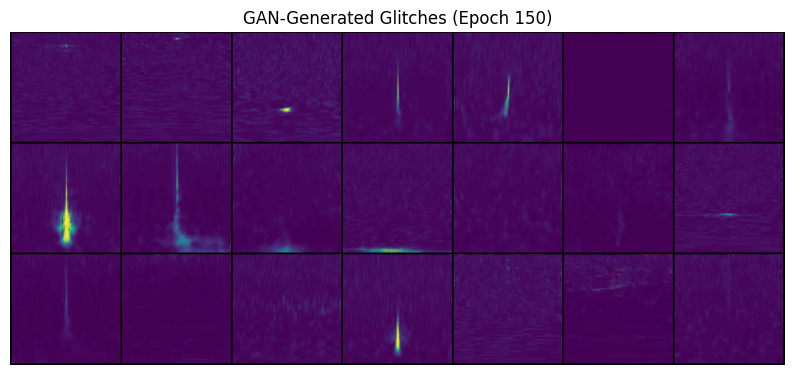

In [ ]:
grid_path = '/content/drive/MyDrive/GAN128_RGB_Tuned/Samples_Epoch_050/epoch_150.png'
img = Image.open(grid_path)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.title("GAN-Generated Glitches (Epoch 150)")
plt.show()

In [ ]:
ckpt = torch.load(f"{checkpoint_dir}/ckpt_epoch_150.pth")

G = Generator().to(device)
G.load_state_dict(ckpt['G'])

# Manually increase dropout after loading
G.model[3].p = 0.35
print(f" Generator dropout updated to: {G.model[3].p}")

opt_G = optim.Adam(G.parameters(), lr=lr_g, betas=betas)
G_ema.load_state_dict(ckpt['G_ema'])
D.load_state_dict(ckpt['D'])
opt_D.load_state_dict(ckpt['opt_D'])
loss_history = ckpt['loss']
start_epoch = ckpt['epoch'] + 1
end_epoch = 175

for param_group in opt_D.param_groups:
    param_group['lr'] = 0.000025

print(f" Discriminator LR set to: {opt_D.param_groups[0]['lr']}")

train_gan_stage(start_epoch, end_epoch, G, D, G_ema, opt_G, opt_D, scaler, dataloader, loss_history)


 Generator dropout updated to: 0.35
 Discriminator LR set to: 2.5e-05
 Starting training from epoch 150 to 175...


<ipython-input-112-2c186ef304c8>:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-112-2c186ef304c8>:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[Epoch 151] G: 12.2604 | D: 0.1804
[Epoch 152] G: 8.2543 | D: 0.1762
[Epoch 153] G: 6.6562 | D: 0.1815
[Epoch 154] G: 6.0704 | D: 0.1836
[Epoch 155] G: 5.6461 | D: 0.1937
[Epoch 156] G: 4.6260 | D: 0.2110
[Epoch 157] G: 4.0805 | D: 0.2155
[Epoch 158] G: 3.9359 | D: 0.2194
[Epoch 159] G: 3.8962 | D: 0.2232
[Epoch 160] G: 3.7729 | D: 0.2249
[Epoch 161] G: 3.7457 | D: 0.2286
[Epoch 162] G: 3.6368 | D: 0.2309
[Epoch 163] G: 3.7822 | D: 0.2325
[Epoch 164] G: 3.8906 | D: 0.2297
[Epoch 165] G: 3.7254 | D: 0.2369
[Epoch 166] G: 3.7635 | D: 0.2375
[Epoch 167] G: 3.8306 | D: 0.2384
[Epoch 168] G: 3.5816 | D: 0.2451
[Epoch 169] G: 3.5978 | D: 0.2475
[Epoch 170] G: 3.5908 | D: 0.2478
[Epoch 171] G: 3.5547 | D: 0.2462
[Epoch 172] G: 3.6959 | D: 0.2479
[Epoch 173] G: 3.6442 | D: 0.2389
[Epoch 174] G: 3.5911 | D: 0.2423
[Epoch 175] G: 3.6486 | D: 0.2426
 Saved image grid for epoch 175: /content/drive/MyDrive/GAN128_RGB_Tuned/Samples_Epoch_050/epoch_175.png
 Finished training stage: 150–175


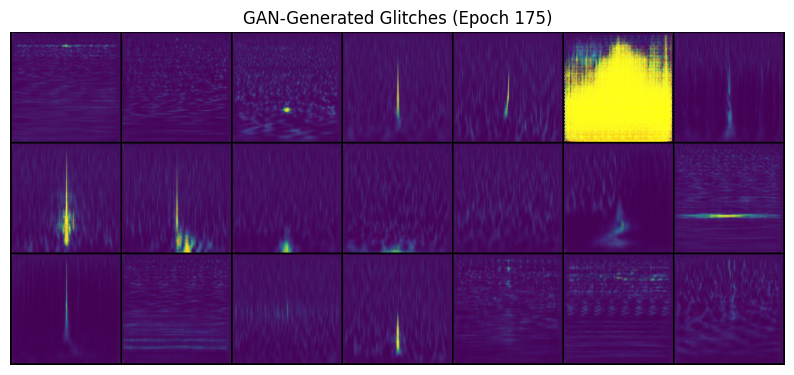

In [ ]:
grid_path = '/content/drive/MyDrive/GAN128_RGB_Tuned/Samples_Epoch_050/epoch_175.png'
img = Image.open(grid_path)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.title("GAN-Generated Glitches (Epoch 175)")
plt.show()

In [ ]:
ckpt = torch.load(f"{checkpoint_dir}/ckpt_epoch_175.pth")
G = Generator().to(device)
G.load_state_dict(ckpt['G'])
G.model[3].p = 0.35
print(f" Generator dropout set to: {G.model[3].p}")
opt_G = optim.Adam(G.parameters(), lr=lr_g, betas=betas)

G_ema.load_state_dict(ckpt['G_ema'])
D.load_state_dict(ckpt['D'])
opt_D.load_state_dict(ckpt['opt_D'])
loss_history = ckpt['loss']

for param_group in opt_D.param_groups:
    param_group['lr'] = 0.000025
print(f" Discriminator LR set to: {opt_D.param_groups[0]['lr']}")

start_epoch = ckpt['epoch'] + 1
end_epoch = 200

train_gan_stage(start_epoch, end_epoch, G, D, G_ema, opt_G, opt_D, scaler, dataloader, loss_history)


 Generator dropout set to: 0.35
 Discriminator LR set to: 2.5e-05
 Starting training from epoch 175 to 200...


<ipython-input-129-1c7d45aa743a>:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-129-1c7d45aa743a>:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[Epoch 176] G: 3.6945 | D: 0.2483
[Epoch 177] G: 3.6198 | D: 0.2515
[Epoch 178] G: 3.6123 | D: 0.2525
[Epoch 179] G: 3.5272 | D: 0.2544
[Epoch 180] G: 3.6710 | D: 0.2514
[Epoch 181] G: 3.6087 | D: 0.2501
[Epoch 182] G: 3.6695 | D: 0.2551
[Epoch 183] G: 3.5894 | D: 0.2638
[Epoch 184] G: 3.8101 | D: 0.2460
[Epoch 185] G: 3.4994 | D: 0.2635
[Epoch 186] G: 3.7310 | D: 0.2573
[Epoch 187] G: 3.7140 | D: 0.2517
[Epoch 188] G: 3.6571 | D: 0.2581
[Epoch 189] G: 3.6581 | D: 0.2564
[Epoch 190] G: 3.4507 | D: 0.2642
[Epoch 191] G: 3.3532 | D: 0.2667
[Epoch 192] G: 3.4256 | D: 0.2731
[Epoch 193] G: 3.5296 | D: 0.2666
[Epoch 194] G: 3.4937 | D: 0.2676
[Epoch 195] G: 3.5675 | D: 0.2641
[Epoch 196] G: 3.6579 | D: 0.2636
[Epoch 197] G: 3.4795 | D: 0.2621
[Epoch 198] G: 3.4410 | D: 0.2663
[Epoch 199] G: 3.6796 | D: 0.2615
[Epoch 200] G: 3.4511 | D: 0.2599
 Saved image grid for epoch 200: /content/drive/MyDrive/GAN128_RGB_Tuned/Samples_Epoch_050/epoch_200.png
 Finished training stage: 175–200


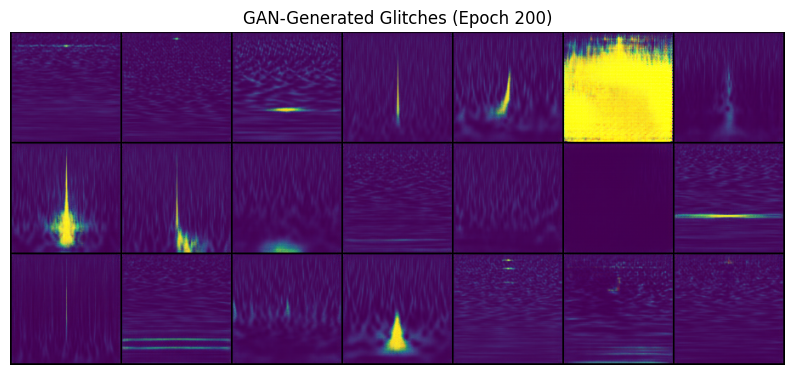

In [ ]:
grid_path = '/content/drive/MyDrive/GAN128_RGB_Tuned/Samples_Epoch_050/epoch_200.png'
img = Image.open(grid_path)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.title("GAN-Generated Glitches (Epoch 200)")
plt.show()

In [ ]:
ckpt = torch.load(f"{checkpoint_dir}/ckpt_epoch_200.pth")
G = Generator().to(device)
G.load_state_dict(ckpt['G'])
print(f" Generator dropout remains: {G.model[3].p}")
opt_G = optim.Adam(G.parameters(), lr=lr_g, betas=betas)
G_ema.load_state_dict(ckpt['G_ema'])
D.load_state_dict(ckpt['D'])
opt_D.load_state_dict(ckpt['opt_D'])
loss_history = ckpt['loss']
print(f" Discriminator LR remains: {opt_D.param_groups[0]['lr']}")
start_epoch = ckpt['epoch'] + 1
end_epoch = 250

train_gan_stage(start_epoch, end_epoch, G, D, G_ema, opt_G, opt_D, scaler, dataloader, loss_history)


 Generator dropout remains: 0.3
 Discriminator LR remains: 2.5e-05
 Starting training from epoch 200 to 250...


<ipython-input-129-1c7d45aa743a>:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-129-1c7d45aa743a>:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[Epoch 201] G: 3.4013 | D: 0.2728
[Epoch 202] G: 3.5075 | D: 0.2701
[Epoch 203] G: 3.5159 | D: 0.2629
[Epoch 204] G: 3.5937 | D: 0.2607
[Epoch 205] G: 3.4937 | D: 0.2652
[Epoch 206] G: 3.7485 | D: 0.2604
[Epoch 207] G: 3.4775 | D: 0.2615
[Epoch 208] G: 3.3925 | D: 0.2739
[Epoch 209] G: 3.2525 | D: 0.2745
[Epoch 210] G: 3.5974 | D: 0.2814
[Epoch 211] G: 3.4198 | D: 0.2760
[Epoch 212] G: 3.3671 | D: 0.2827
[Epoch 213] G: 3.3607 | D: 0.2790
[Epoch 214] G: 3.1788 | D: 0.2925
[Epoch 215] G: 3.3722 | D: 0.2819
[Epoch 216] G: 3.4179 | D: 0.2839
[Epoch 217] G: 3.3244 | D: 0.2780
[Epoch 218] G: 3.4889 | D: 0.2722
[Epoch 219] G: 3.2670 | D: 0.2876
[Epoch 220] G: 3.2511 | D: 0.2801
[Epoch 221] G: 3.2961 | D: 0.2786
[Epoch 222] G: 3.4054 | D: 0.2789
[Epoch 223] G: 3.4498 | D: 0.2774
[Epoch 224] G: 3.0674 | D: 0.2968
[Epoch 225] G: 3.4095 | D: 0.2745
[Epoch 226] G: 3.4342 | D: 0.2779
[Epoch 227] G: 3.4157 | D: 0.2799
[Epoch 228] G: 3.4691 | D: 0.2762
[Epoch 229] G: 3.3401 | D: 0.2802
[Epoch 230] G:

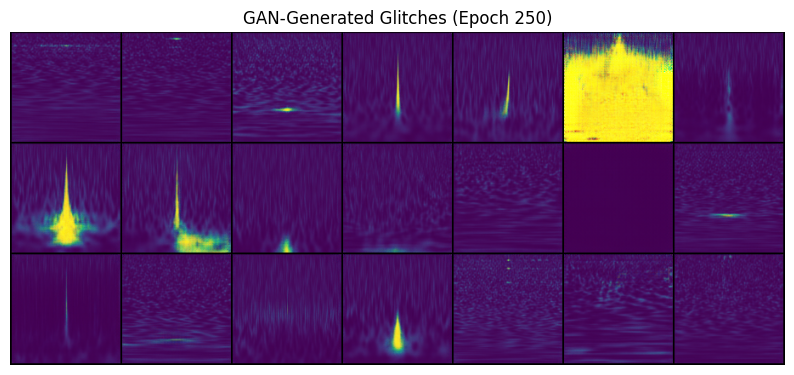

In [ ]:
grid_path = '/content/drive/MyDrive/GAN128_RGB_Tuned/Samples_Epoch_050/epoch_250.png'
img = Image.open(grid_path)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.title("GAN-Generated Glitches (Epoch 250)")
plt.show()

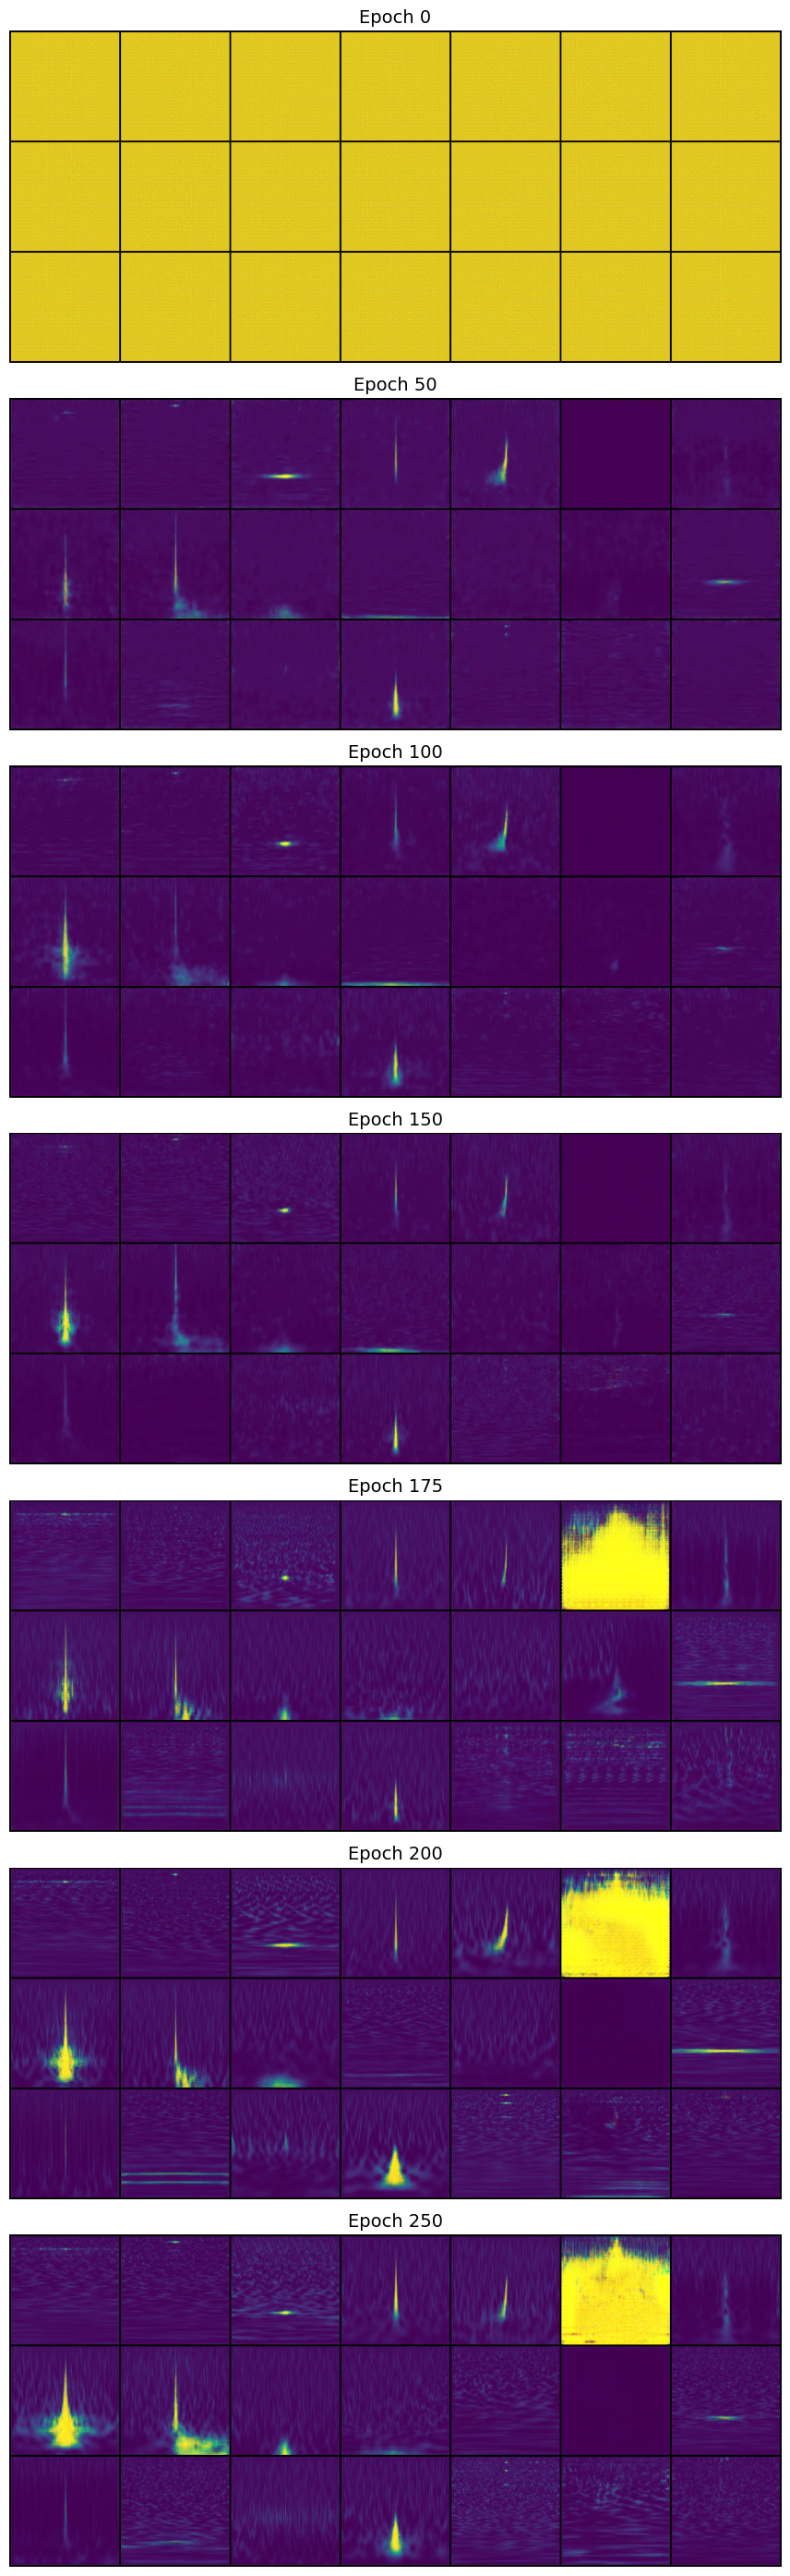

In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image
epoch_paths = {
    0:   "/content/drive/MyDrive/GAN128_RGB_Tuned/Samples_Epoch_050/epoch_000.png",
    50:  "/content/drive/MyDrive/GAN128_RGB_Tuned/Samples_Epoch_050/epoch_050.png",
    100: "/content/drive/MyDrive/GAN128_RGB_Tuned/Samples_Epoch_050/epoch_100.png",
    150: "/content/drive/MyDrive/GAN128_RGB_Tuned/Samples_Epoch_050/epoch_150.png",
    175: "/content/drive/MyDrive/GAN128_RGB_Tuned/Samples_Epoch_050/epoch_175.png",
    200: "/content/drive/MyDrive/GAN128_RGB_Tuned/Samples_Epoch_050/epoch_200.png",
    250: "/content/drive/MyDrive/GAN128_RGB_Tuned/Samples_Epoch_050/epoch_250.png",
}

images = []
labels = []

for epoch, path in epoch_paths.items():
    if os.path.exists(path):
        images.append(Image.open(path))
        labels.append(f"Epoch {epoch}")
    else:
        print(f" Missing: {path}")

plt.figure(figsize=(12, 4 * len(images)))

for i, img in enumerate(images):
    plt.subplot(len(images), 1, i + 1)
    plt.imshow(img)
    plt.title(labels[i], fontsize=14)
    plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
torch.save(G_ema.state_dict(), "/content/drive/MyDrive/GAN128_RGB_Tuned/final_generator_ema_ep250.pth")


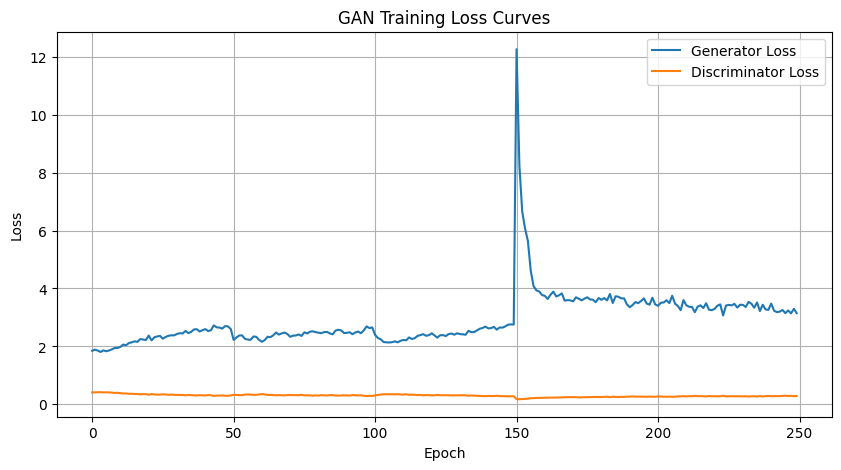

In [ ]:
import matplotlib.pyplot as plt

# Plot Generator and Discriminator losses
plt.figure(figsize=(10, 5))
plt.plot(loss_history['G'], label='Generator Loss')
plt.plot(loss_history['D'], label='Discriminator Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("GAN Training Loss Curves")
plt.legend()
plt.grid(True)
plt.show()
